# One Plane 2D model
- The following notebook contains the solution for optimal control for the one plane problem in 2D
- The solver is in the package "Model_2D_Package"
- First is the solution from the bolza definition
- Then the solution from the min -w, where w<=h(t) for all t
- Last is a function for reconstructing a more detail trajectory when solving for low u values

In [27]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np
from casadi import *

import importlib
import Model_2D_Package.One_Plane_2D_solvers as model
importlib.reload(model)



<module 'Model_2D_Package.One_Plane_2D_solvers' from 'C:\\Users\\irmas\\Documents\\TUM\\CaseCourse\\CasADi\\Main\\Model_2D\\Model_2D_Package\\One_Plane_2D_solvers.py'>

# Plot wind

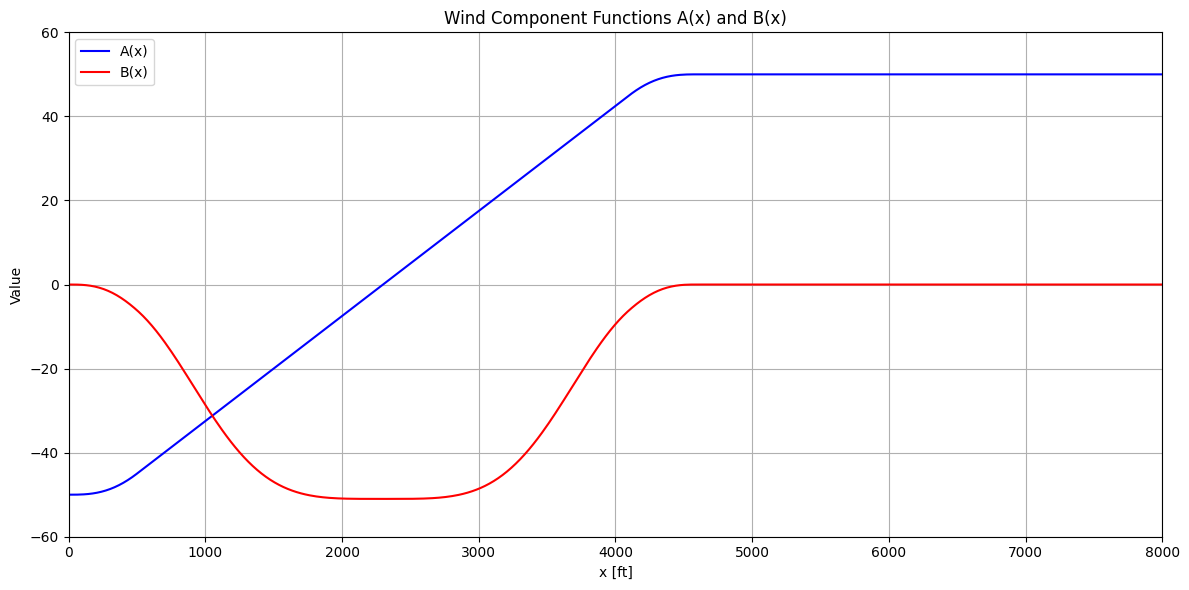

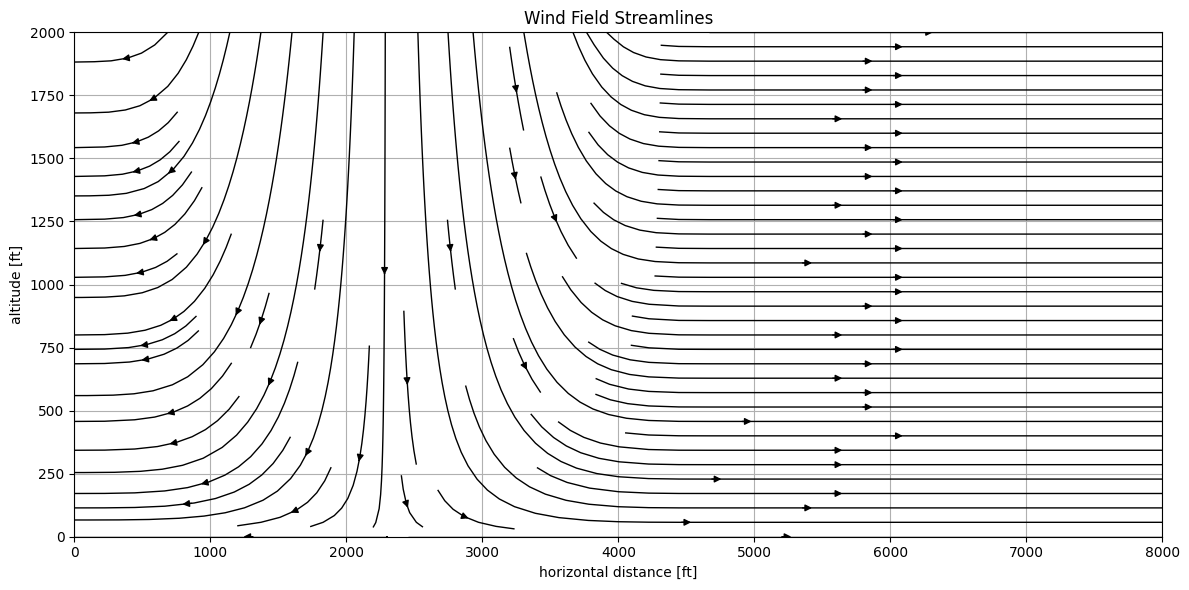

In [28]:

# Constants from table
a = 6e-8
b = -4e-11
c = -np.log(25 / 30.6) * 1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
k = 1

# Wind component functions
def A_func(x):
    if x <= 500:
        return -50 + a * x**3 + b * x**4
    elif x <= 4100:
        return 0.025 * (x - 2300)
    elif x <= 4600:
        return 50 - a * (4600 - x)**3 - b * (4600 - x)**4
    else:
        return 50

def B_func(x):
    if x <= 500:
        return d * x**3 + e * x**4
    elif x <= 4100:
        return -51 * np.exp(-c * (x - 2300)**4)
    elif x <= 4600:
        return d * (4600 - x)**3 + e * (4600 - x)**4
    else:
        return 0

# Vectorize functions
A_vec = np.vectorize(A_func)
B_vec = np.vectorize(B_func)

# 1. Plot A(x) and B(x)
x_vals = np.linspace(0, 8000, 500)
plt.figure(figsize=(12, 6))
plt.xlim([0, 8000])
plt.ylim([-60, 60])
plt.plot(x_vals, A_vec(x_vals), label='A(x)', color='blue')
plt.plot(x_vals, B_vec(x_vals), label='B(x)', color='red')
plt.title('Wind Component Functions A(x) and B(x)')
plt.xlabel('x [ft]')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Wind field plot using streamplot (to look like dotted flow lines)
x_grid = np.linspace(0, 8000, 200)
h_grid = np.linspace(0, 2000, 100)
X, H = np.meshgrid(x_grid, h_grid)

U = k * A_vec(X)
V = k * H * B_vec(X) / h_star

plt.figure(figsize=(12, 6))
plt.streamplot(
    X, H, U, V,
    color='black', linewidth=1, density=1.2, arrowsize=1
)
plt.xlabel('horizontal distance [ft]')
plt.ylabel('altitude [ft]')
plt.title('Wind Field Streamlines')
plt.xlim([0, 8000])
plt.ylim([0, 2000])
plt.grid(True)
plt.tight_layout()
plt.show()



# Bolza and min -w model

Total number of variables............................:      480
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      160
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 850

                                   (scaled)                 (unscaled)
Objective...............:   3.3329203905804095e+09    3.3329203905804096e+17
Dual infeasibility......:   3.3490359783172607e-06    3.3490359783172607e+02
Constraint violation....:   4.5474735088646412e-13    4.5474735088646412e-13
Variable bound violation:   1.0000000001675335e-08    1.0000000001675335e-08
Complementar

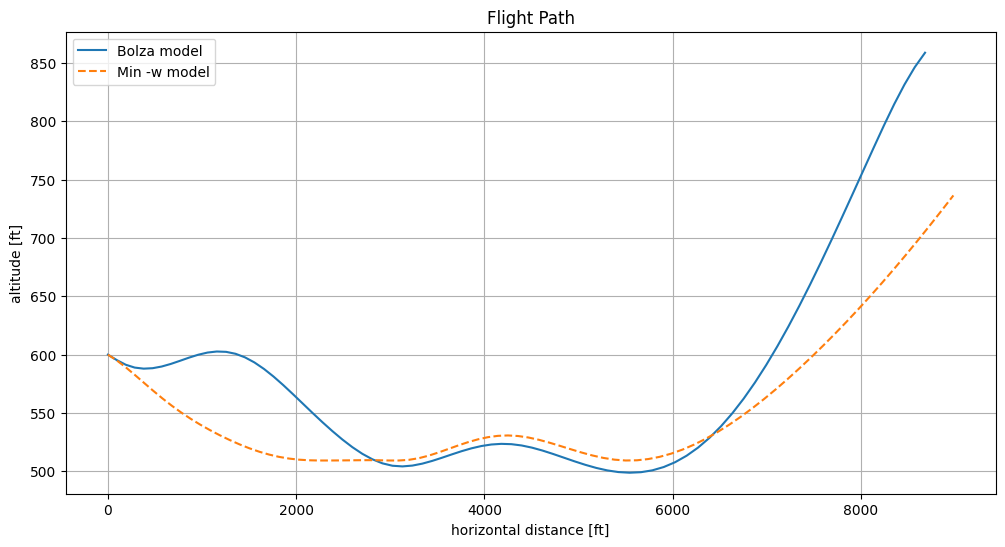

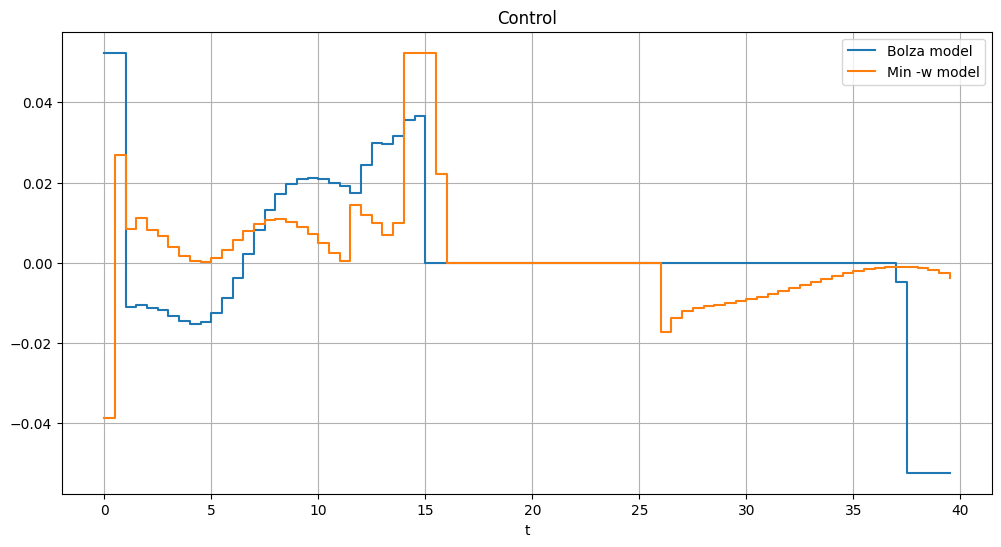

In [16]:
importlib.reload(model)
k = 1
w_opt1,J_opt1 = model.solve_ocp_one_plane_bolza(k_value=k)
w_opt2,J_opt2 = model.solve_ocp_one_plane_min_h(k_value=k)


X1, U1, _, T1 = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt1, True),k)
X2, U2, _, T2 = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt2, False),k)


x1_opt1 = X1[0::5]
x2_opt1 = X1[1::5]
x1_opt2 = X2[0::5]
x2_opt2 = X2[1::5]


print('Bolza model min altitude: ' + str(min(x2_opt1)) + ' ft')
print('min -w model min altitude: ' + str(min(x2_opt2)) + ' ft')

plt.figure(figsize=(12, 6))
plt.clf()
plt.plot(x1_opt1, x2_opt1, '-', label='Bolza model')
plt.plot(x1_opt2, x2_opt2, '--', label='Min -w model')
plt.xlabel('horizontal distance [ft]')
plt.ylabel('altitude [ft]')
plt.title('Flight Path')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.clf()
plt.step(T1[:-1], U1, where='post', label='Bolza model')
plt.step(T2[:-1], U2, where='post', label='Min -w model')
plt.xlabel('t')
plt.title('Control')
plt.legend()
plt.grid()
plt.show()



# MC simulations

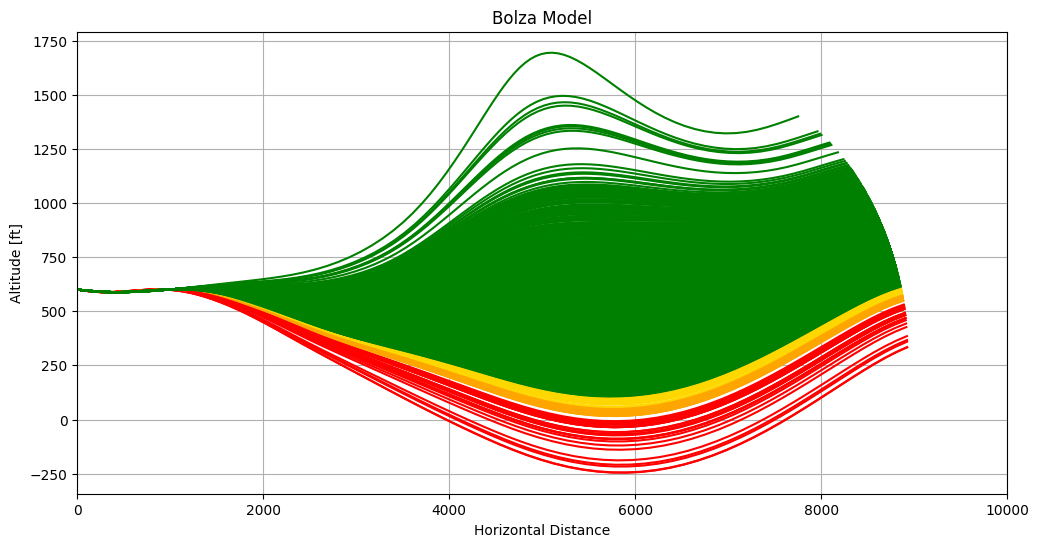

In [12]:
# Bolza

M = 1000
k_samples = np.random.normal(loc=1.0, scale=0.25, size=M)
min_hs = []
plt.figure(figsize=(12, 6))
for i in range(M):
    X, U, J, T = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt1, True),k_samples[i],1)
    x1_opt = X[0::5]  # start at index 0, get every 6th:
    x2_opt = X[1::5]
    min_h=(min(x2_opt))
    min_hs.append(min_h)
    color = 'red' if min_h <= 0 else 'orange' if min_h <= 50 else 'gold' if min_h <= 100 else 'green'
    plt.plot(x1_opt, x2_opt, color=color)
    
plt.xlabel('Horizontal Distance')
plt.ylabel('Altitude [ft]')
plt.title('Bolza Model')
plt.grid(True)
plt.xlim([0, 10000])
plt.show()


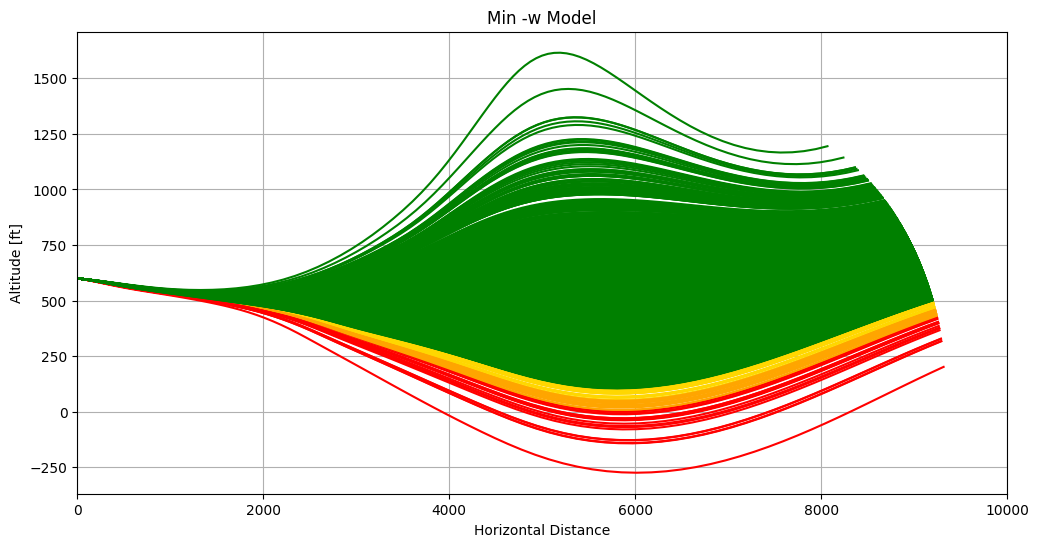

In [13]:
# min -w  model

M = 1000
k_samples = np.random.normal(loc=1.0, scale=0.25, size=M)
min_hs = []
plt.figure(figsize=(12, 6))
for i in range(M):
    X, U, J, T = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt2, False),k_samples[i],1)
    x1_opt = X[0::5]  # start at index 0, get every 6th:
    x2_opt = X[1::5]
    min_h=(min(x2_opt))
    min_hs.append(min_h)
    color = 'red' if min_h <= 0 else 'orange' if min_h <= 50 else 'gold' if min_h <= 100 else 'green'
    plt.plot(x1_opt, x2_opt, color=color)
    
plt.xlabel('Horizontal Distance')
plt.ylabel('Altitude [ft]')
plt.title('Min -w Model')
plt.grid(True)
plt.xlim([0, 10000])
plt.show()

# Individual Models with wind

Total number of variables............................:      480
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      160
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 850

                                   (scaled)                 (unscaled)
Objective...............:   3.3329203905804095e+09    3.3329203905804096e+17
Dual infeasibility......:   3.3490359783172607e-06    3.3490359783172607e+02
Constraint violation....:   4.5474735088646412e-13    4.5474735088646412e-13
Variable bound violation:   1.0000000001675335e-08    1.0000000001675335e-08
Complementar

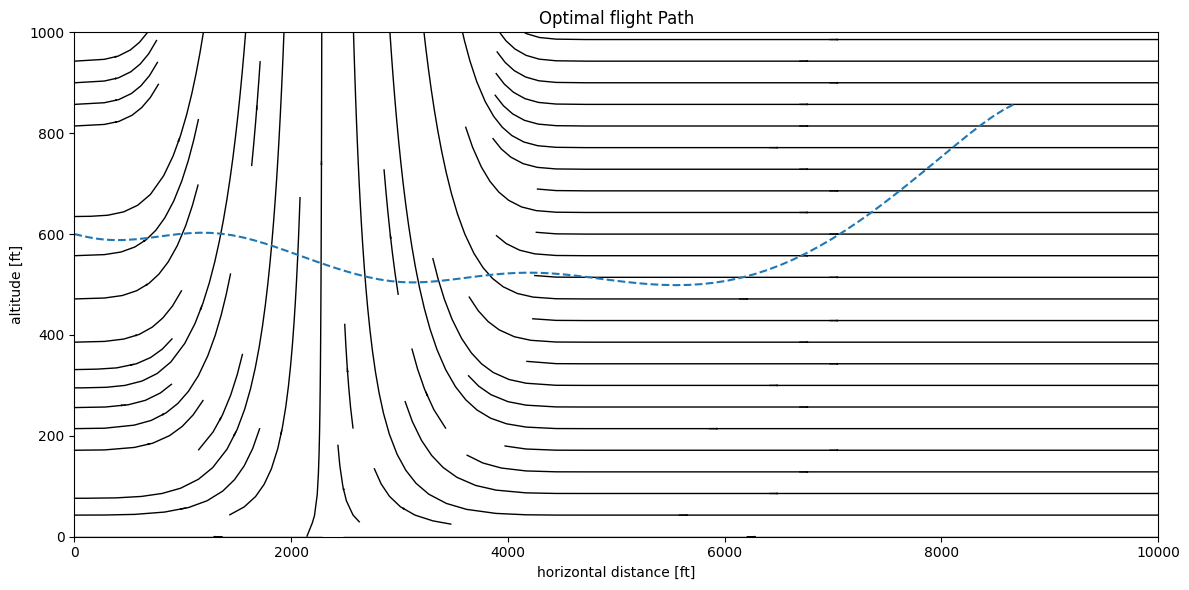

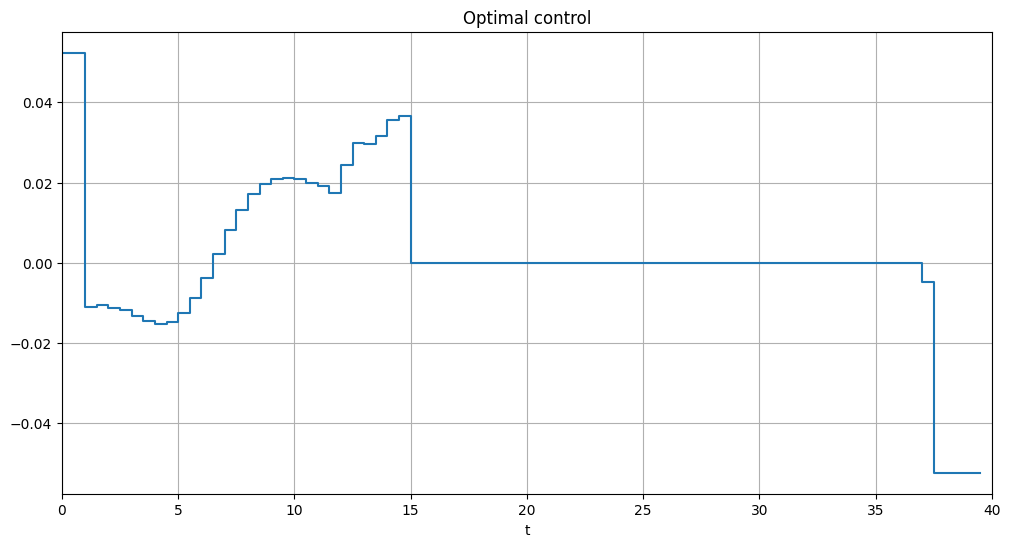

In [30]:
# Bolza
k = 1
w_opt,J_opt = model.solve_ocp_one_plane_bolza(k)
print(J_opt)
model.plot_one_plane_2D_with_wind(w_opt,True,k)

Total number of variables............................:      481
                     variables with only lower bounds:       81
                variables with lower and upper bounds:       80
                     variables with only upper bounds:       80
Total number of equality constraints.................:      401
Total number of inequality constraints...............:      160
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0


Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:  -5.0924153728914320e+02   -5.0924153728914320e+02
Dual infeasibility......:   5.0888810190455741e-10    5.0888810190455741e-10
Constraint violation....:   1.0400909639420001e-11    1.2505552149377763e-11
Variable bound violation:   9.9580854118208606e-09    9.9580854118208606e-09
Complementari

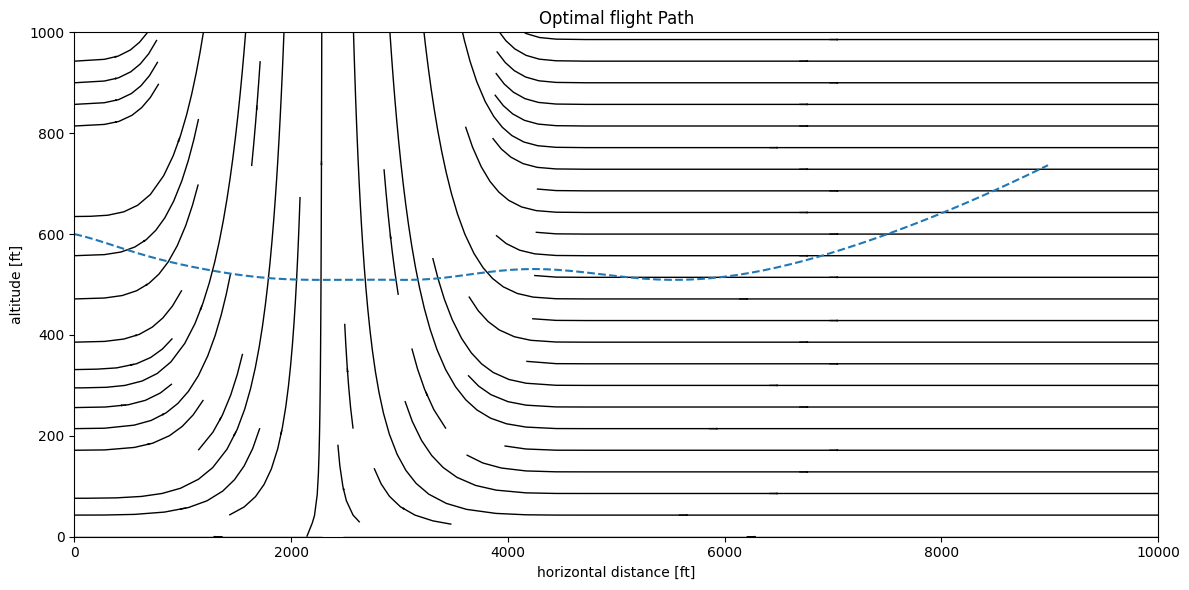

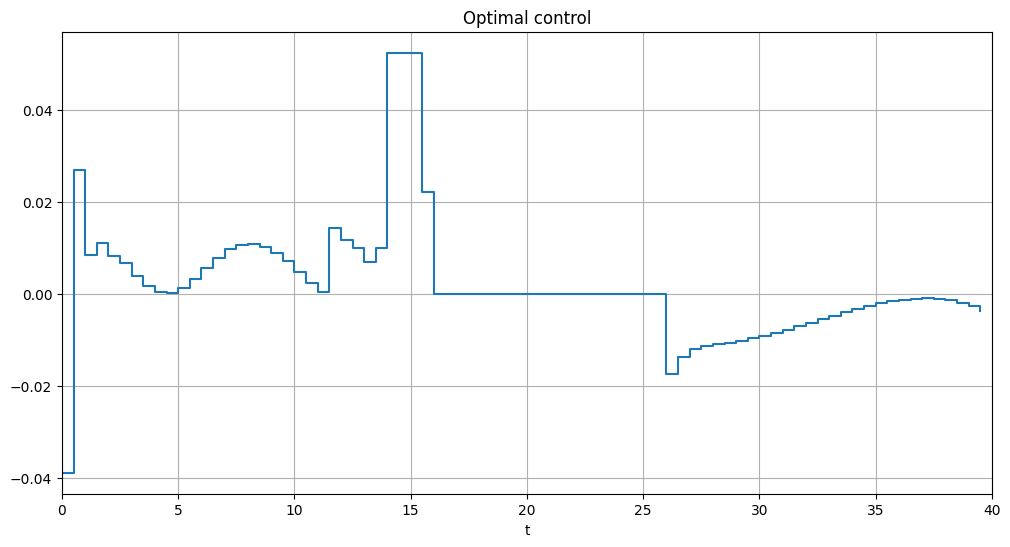

In [31]:
# min -w
k = 1
w_opt,J_opt = model.solve_ocp_one_plane_min_h(k)
print(-J_opt)
model.plot_one_plane_2D_with_wind(w_opt,False,k)

# Reconstruction function
Reconstructing the state trajectory with a smaller time step

Optimal cost J* = 3.87075e+17
509.17124265858126


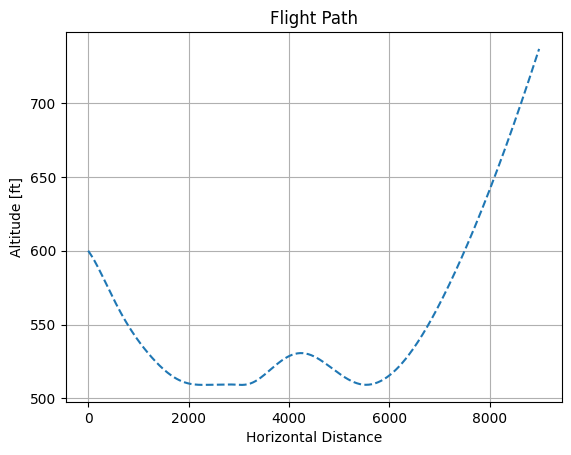

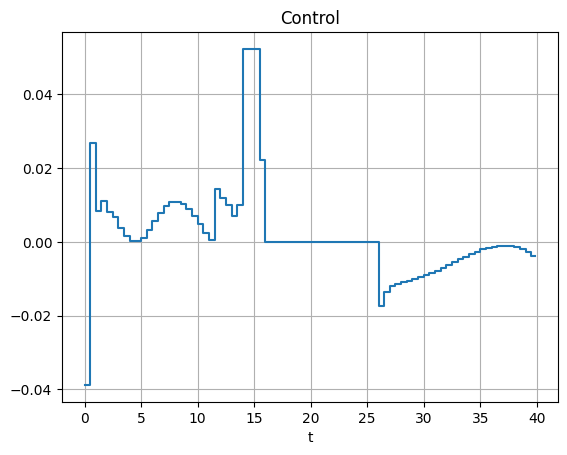

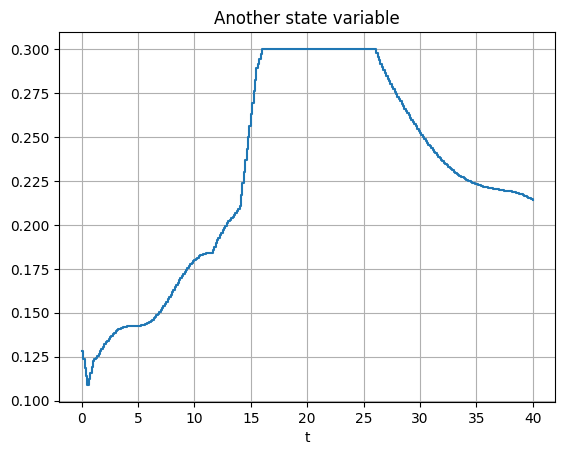

In [24]:


# Plot
X,U,J,T = model.reconstruction_one_plane_2D(model.u_opt_return(w_opt, False), k_value=1, multipler=4)


x1_opt = X[0::5]    # start at index 0, get every 5th:
x2_opt = X[1::5]   
x3_opt = X[2::5]  
x4_opt = X[3::5] 
x5_opt = X[4::5]


print("Optimal cost J* =", J)
print(min(x2_opt))

plt.figure(1)
plt.clf()
plt.plot(x1_opt, x2_opt, '--')
plt.xlabel('Horizontal Distance')
plt.ylabel('Altitude [ft]')
plt.title('Flight Path')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(T[:-1], U, where='post')
plt.xlabel('t')
plt.title('Control')
plt.grid()
plt.show()  

plt.figure(3)
plt.clf()
plt.step(T, x5_opt, where='post')
plt.xlabel('t')
plt.title('Another state variable')
plt.grid()
plt.show() 

